In [28]:
'''Modified from sklearn documentation: https://scikit-learn.org/stable/modules/compose.html
'''
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from pcsp import PCSPipeline, ModuleSet, Module # must install pcsp first (pip install pcsp)
from pcsp.pipeline import build_graph
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from functools import partial
import itertools
import networkx as nx
np.set_printoptions(threshold=5) # to limit printing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Entire pipeline

In [29]:
# subsample data
np.random.seed(13)
X, y = make_classification(n_samples=50, n_features=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
subsampling_funcs = [partial(resample,
                            n_samples=int(X_train.shape[0]*0.3),
                            random_state=i)
                     for i in range(3)]
subsampling_set = ModuleSet(name='subsampling',
                            modules=subsampling_funcs)
# todo: shouldn't have to pass list for first args
X_all, y_all = subsampling_set([X_train], [y_train]) # subsampling_set([X_train, X_train], [y_train, y_train]) # artificially make it seem like there are multiple dsets (data_0 and data_1)

# fit models
modeling_set = ModuleSet(name='modeling',
                         modules=[LogisticRegression(max_iter=1000, tol=0.1),
                                  DecisionTreeClassifier()],
                         module_keys=["LR", "DT"])
models = modeling_set.fit(X_all, y_all)  # ModuleSet needs to store something for this call to work (makes models kind of useless)

# get predictions
X_all["test"] = X_test
y_all["test"] = y_test
preds_all = modeling_set.predict(X_all)

# get metrics
hard_metrics_set = ModuleSet(name='hard_metrics',
                             modules=[accuracy_score, balanced_accuracy_score],
                             module_keys=["Acc", "Bal_Acc"])
hard_metrics = hard_metrics_set.evaluate(y_all, preds_all)
for k in hard_metrics:
    print(k, hard_metrics[k])

(('data_0', 'subsampling_0', 'LR'), ('data_0', 'subsampling_0'), 'Acc') 0.9090909090909091
(('data_0', 'subsampling_0', 'LR'), ('data_0', 'subsampling_0'), 'Bal_Acc') 0.8333333333333333
(('data_0', 'subsampling_0', 'DT'), ('data_0', 'subsampling_0'), 'Acc') 0.9090909090909091
(('data_0', 'subsampling_0', 'DT'), ('data_0', 'subsampling_0'), 'Bal_Acc') 0.8333333333333333
(('data_0', 'subsampling_1', 'LR'), ('data_0', 'subsampling_0'), 'Acc') 0.9090909090909091
(('data_0', 'subsampling_1', 'LR'), ('data_0', 'subsampling_0'), 'Bal_Acc') 0.8333333333333333
(('data_0', 'subsampling_1', 'DT'), ('data_0', 'subsampling_0'), 'Acc') 0.9090909090909091
(('data_0', 'subsampling_1', 'DT'), ('data_0', 'subsampling_0'), 'Bal_Acc') 0.8333333333333333
(('data_0', 'subsampling_2', 'LR'), ('data_0', 'subsampling_0'), 'Acc') 0.9090909090909091
(('data_0', 'subsampling_2', 'LR'), ('data_0', 'subsampling_0'), 'Bal_Acc') 0.8333333333333333
(('data_0', 'subsampling_2', 'DT'), ('data_0', 'subsampling_0'), 'Acc'

# inspect the pipeline

ModuleSet(hard_metrics)
ModuleSet(subsampling)
ModuleSet(modeling)
ModuleSet(subsampling)


/accounts/projects/vision/chandan/pcs-pipeline/pcsp/pipeline.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


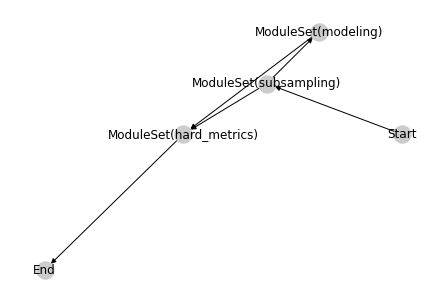

In [30]:
G = build_graph(hard_metrics, draw=True)

# tracking things w Pipeline (deprecated)

In [ ]:
p = PCSPipeline()

In [ ]:
p.steps = [subsampling_set, modeling_set, soft_metrics_set] # how to deal w/ hard metrics?

In [ ]:
p.run([X_train], [y_train])

In [ ]:
df = p.generate_names()
df['soft_metrics'] = soft_metrics
df